## Endogenous Grid Method
An implementation of the Endogenous Grid Method. This is pretty much identical to the implementation from the V1 exercises. 

#### Preliminaries

In [1]:
## load some packages
import matplotlib.pyplot as plt
import numpy as np
import warnings

## config
# params
BETA = 0.99
GAMMA = 2.
R = 1 / BETA
ENDOWMENT = np.array([1, 2.5])  # low and high endowments
L_L = 0.4  # probability of staying low
H_H = 0.8  # probability of staying high
TRAN_MAT = np.array([[L_L, 1-H_H], [1-L_L, H_H]])  # transition matrix

# grids
A_MIN = 0
A_MAX = 100
N_A = 101
GRID = np.linspace(A_MIN**0.25, A_MAX**0.25, N_A)**4

#### The Model
Households get an endowment $e$ that fluctuates exogenous between $e_l$ and $e_h$ where $e_l < e_h$ with transition probabilities $\Pi$. The household can choose to either invest their earnings in a risk-free bond that returns $R$ or consume it with preferences given by
$$
    \mathbb{E} \sum_{t=0}^\infty \beta^t \frac{c_t^{1-\gamma}}{1-\gamma}
$$
giving them the budget constraint
$$
    a' + c = R a + e
$$
where $a' \geq \underline a$ (borrowing constraint).

The Bellman equation becomes
$$
    V(a, e) = \max_{a' \geq \underline a} \frac{\left(R a + e - a'\right)^{1-\gamma}}{1-\gamma} + \beta \mathbb{E} V(a', e').
$$

The FOC and envelope conditions get the Euler Equation
$$
    c^{-\gamma} = \beta R \mathbb{E} c^{\prime -\gamma}.
$$

| Variable | Meaning |
| --- | --- |
| $c$ | Consumption |
| $a$ | Start of period savings |
| $e$ | Endowment |

| Parameter | Meaning |
| --- | --- |
| $\gamma$ | Risk aversion |
| $\beta$ | Discount factor |
| $R$ | Interest rate |
| $\Pi$ | Transition probabilities |

#### Endogenous Grid Method
To solve the model, we're looking for a savings function $g(a, e)$ that maximizes utility. To find this function, we'll assume the function takes a certain value $g$ and that at the end of the period the household saves a certain amount $a'$. Then using the budget constraint, we know
$$
    \mathbb{E} c' = \mathbb{E} Ra' + e' - g(a', e')
$$
which, using the Euler Equation, means
$$
    c = \left(\beta R \mathbb{E} c^{\prime -\gamma}\right)^\frac{-1}{\gamma}.
$$
Finally, we can use this to solve for how many assets the household started the period with as
$$
    a = \frac{1}{R} \left(a' + c - e\right).
$$

We'll solve this along a grid and interpolate to get our new guess for $g$, the repeat the process until $g$ converges to a single value.

In [2]:
def euler_back(g, a_p=GRID):
    '''
    Finds a savings function given a old guess for a savings function
    and gridpoitns
    '''
    c_p = R * a_p[:, None] + ENDOWMENT - g(a_p)  # get next period consumption
    expec_dc_p = c_p ** (-GAMMA) @ TRAN_MAT  # take expectation with deriavtive
    c_t = (BETA * R * expec_dc_p)**(-1/GAMMA)  # consumption now
    a_t = 1/R * (a_p[:, None] + c_t - ENDOWMENT)  # savings at the start of the period

    return a_t

#### Numerical Methods
We'll need to be able to get consumption functions, savings functions, and interpolate to use the method.

In [3]:
def get_linear_interpolation(x, y):
    '''
    Gets a function that performs a linear interpolation between the
    points in x and y

    If check input is left false, the x values should be sorted and 
    unique
    '''
    # setuo
    n = len(x)

    # create and return interpolating function
    def linear_interpolation(X):
        '''
        The function to find the interpolating spline at an X
        '''
        idx = np.minimum(np.maximum(np.searchsorted(x, X, 'right'), 1), n-1)  # min an max make sure that points before/after end up on a line
        x_l = x[idx-1]  # values below the x
        y_l = y[idx-1]
        x_h = x[idx]  # values above the x
        y_h = y[idx]
        m = (y_h - y_l) / (x_h - x_l)  # slope
        return y_l + m * (X - x_l)  
    
    return linear_interpolation


def get_g(a_t, a_p=GRID, spline=get_linear_interpolation):
    '''
    Takes current asset grid and future asset grid and interpolates to
    make a savings function
    '''
    # get interpolating functions
    num_endows = a_t.shape[1]
    splines = [spline(a_t[:, i], a_p) for i in range(num_endows)]

    def g(a_t):
        '''
        Savings function, takes asset grid and returns how much they save
        '''
        a_prime = np.column_stack([splines[i](a_t) for i in range(num_endows)])
        a_prime[a_prime < A_MIN] = A_MIN  # borrowing constraint
        return a_prime
    
    return g


def get_c(g):
    '''
    Takes a saving function and returns the consumption function
    '''
    c = lambda a_t: R*a_t[:, None] + ENDOWMENT - g(a_t)  # consumption = assets + endowment - next assets
    return c

#### Implementation
We'll implement the EGM in a loop updating as we go. When the last iteration and this one are close enough, we exit.

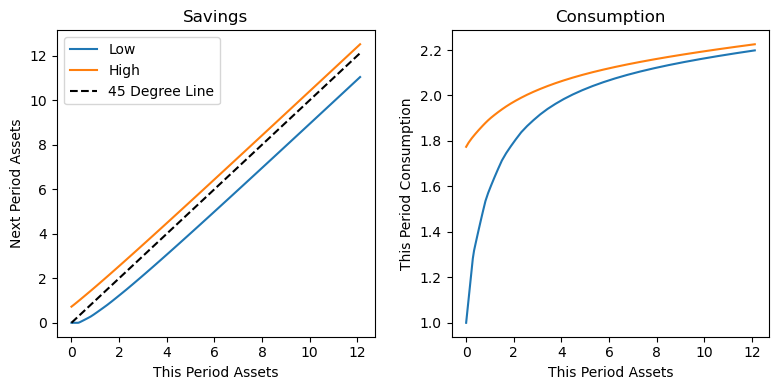

In [4]:
# initial guess
a_t = 10 + 0.1 * np.tile(GRID, ENDOWMENT.shape+(1,)).T  # assumed policy function is that you save this amount from each point in the tiled grid
g = get_g(a_t)

# loop
tol = 1e-10
max_iter = 10000
for _ in range(max_iter):
    # get new consumption function
    last_a_t = a_t
    a_t = euler_back(g)
    g = get_g(a_t)

    # exit condition
    diff = np.abs(a_t - last_a_t).max()
    if diff < tol:
        break
else:
    warnings.warn('Max iteration count exceeded')
c = get_c(g)  # get consumption function

# setup plot
n = 60  # number of gridpoints we plot, most interesting stuff happens early
fig, ax = plt.subplots(1, 2)
fig.set_figwidth(8)
fig.set_figheight(4)
ax[0].set_title('Savings')
ax[0].set_xlabel('This Period Assets')
ax[0].set_ylabel('Next Period Assets')
ax[1].set_title('Consumption')
ax[1].set_xlabel('This Period Assets')
ax[1].set_ylabel('This Period Consumption')

# plot it
ax[0].plot(GRID[:n], g(GRID)[:n], label=['Low', 'High'])
ax[0].plot([A_MIN, GRID[n-1]], [A_MIN, GRID[n-1]], 'k--', label='45 Degree Line')
ax[1].plot(GRID[:n], c(GRID)[:n])

# final things
ax[0].legend()
fig.tight_layout()